In [1]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

In [2]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/GB_pytorch/Lesson_10/'

In [30]:
gest_lable_dic = {1: '02_l',
 3: '04_fist_moved',
 8: '09_c',
 9: '10_down',
 5: '06_index',
 7: '08_palm_moved',
 6: '07_ok',
 4: '05_thumb',
 0: '01_palm',
 2: '03_fist'}


In [3]:
resnet50 = torch.load(MODEL_PATH + 'gest_detection_model.pth' )
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.1 MB/s eta 0:00:00


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [6]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Image saved to {}'.format(filename))
  
  # Show the image which was just taken.
  # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Image saved to photo.jpg


In [52]:
def predict_gesture():
  
    with torch.no_grad():
      img = take_photo()
      display(Image(img))
      img = cv2.imread(img)
      
      transform = transforms.Compose([transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=3),
                              transforms.Resize((256, 256)),
                              transforms.ToTensor()])
      img = transform(img).unsqueeze(0)
      outputs = resnet50(img.to(device))
      print(f'predicted - {gest_lable_dic[int(outputs[0].argmax().item())]}')

<IPython.core.display.Javascript object>

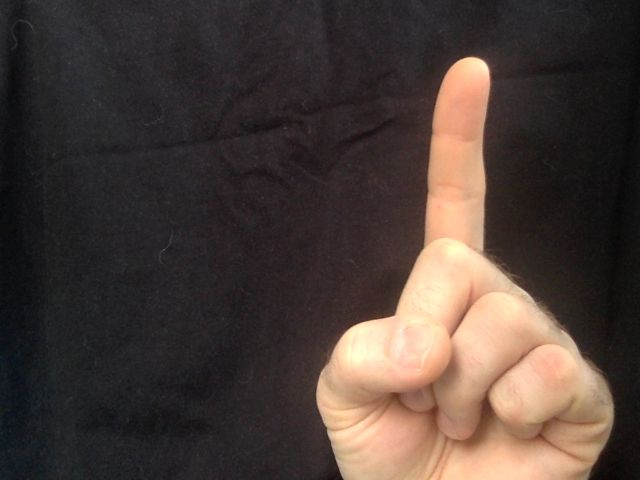

predicted - 07_ok


In [59]:
predict_gesture()     

In [80]:
from facenet_pytorch import MTCNN
from google.colab.patches import cv2_imshow

class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        # self.cap = cv2.VideoCapture(0)
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = torch.load(MODEL_PATH + 'gest_detection_model.pth')
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, gestures):
        """
        Draw landmarks and boxes for each face detected
        """

        try:
            for box, prob, gesture in zip(boxes, probs, gestures):
                print(box, prob, gesture)
                # Draw rectangle on frame
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 155, 255), thickness=2)
                # Show probability. Пишем на рисунке какой жест   
                cv2.putText(frame, gestures[0], (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)

        except:
            print('Something wrong with drawing function!')
            pass

        return frame
    
    # Cropping faces function
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'palm'
        elif digit == 1:
            return 'l'
        elif digit == 2:
            return 'fist'
        elif digit == 3:
            return 'fist_moved'
        elif digit == 4:
            return 'thumb'
        elif digit == 5:
            return 'index'
        elif digit == 6:
            return 'ok'
        elif digit == 7:
            return 'palm_moved'
        elif digit == 8:
            return 'c'
        elif digit == 9:
            return 'down'

    def run(self):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                

        while True:
            # success, frame = cap.read()
            # print(success)

            frame = cv2.imread(take_photo())

            try:                
              # detect face box, probability and landmarks
              boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
              # print(probs)
              gestures = []
        
              if probs[0]:
                transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()])
        
                all_frame = transform(frame).unsqueeze(0)
                gesture = self.emodel(all_frame.to(device))
                gesture = self.digit_to_classname(gesture.argmax())                  
                gestures.append(gesture)
                
                # draw on frame
                self._draw(frame, boxes, probs, gestures)
              else:
                print('We need face')

            except:
                  pass

            cv2_imshow(frame)


            if cv2.waitKey(0):
                break

        cv2.destroyAllWindows()

In [81]:
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)
    

<IPython.core.display.Javascript object>

We need face


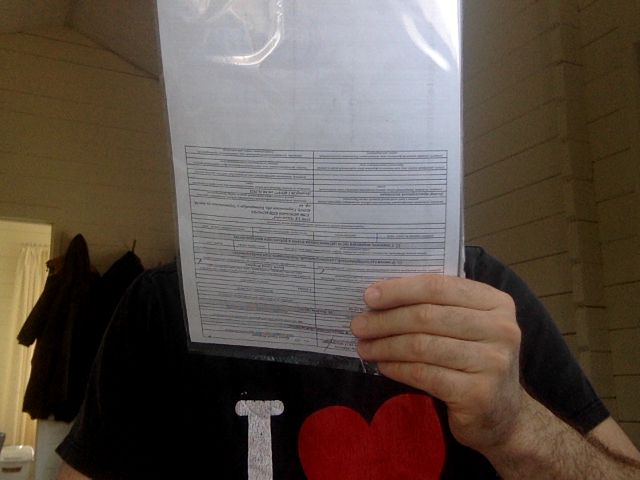

In [84]:
fcd.run()

<IPython.core.display.Javascript object>

[387.03186  112.953064 546.2882   352.63477 ] 0.9934052 ok


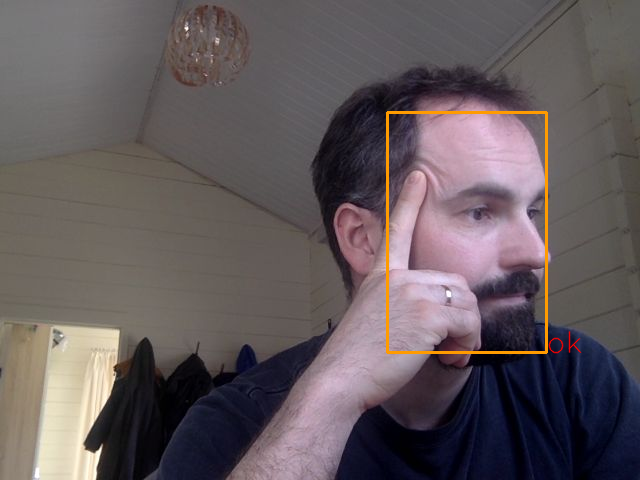

In [97]:
fcd.run()